<a href="https://colab.research.google.com/github/mspsullivan/DataCleaningProject/blob/master/TutorialExtractionAvetisyan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Follow the tutorial page written here: https://kedion.medium.com/ml-security-with-the-adversarial-robustness-toolbox-d173b24e8c1a

In [1]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.7 MB/s eta 0:00:00


In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [4]:
# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")


In [7]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [ ]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 815us/sample - loss: 0.4024 - accuracy: 0.8916
Epoch 2/10
19200/60000 [========>.....................] - ETA: 31s - loss: 0.1125 - accuracy: 0.9676

In [7]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model, 
    clip_values=(min, max)
    )

In [8]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier, 
    eps=0.3
    )

In [9]:
# Generating adversarial images from test images
test_images_adv = attack_fgsm.generate(x=test_images)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


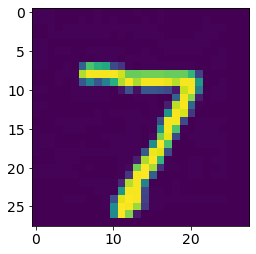

In [18]:
# Viewing an adversarial image
#X = np.expand_dims(test_images_adv[0], axis=1)  # or axis=1
if test_images_adv[0].shape[2] == 1:
    X = test_images_adv[0][:, :, 0]
plt.imshow(X)


In [11]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.03 vs adversarial set test loss: 6.48
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.06


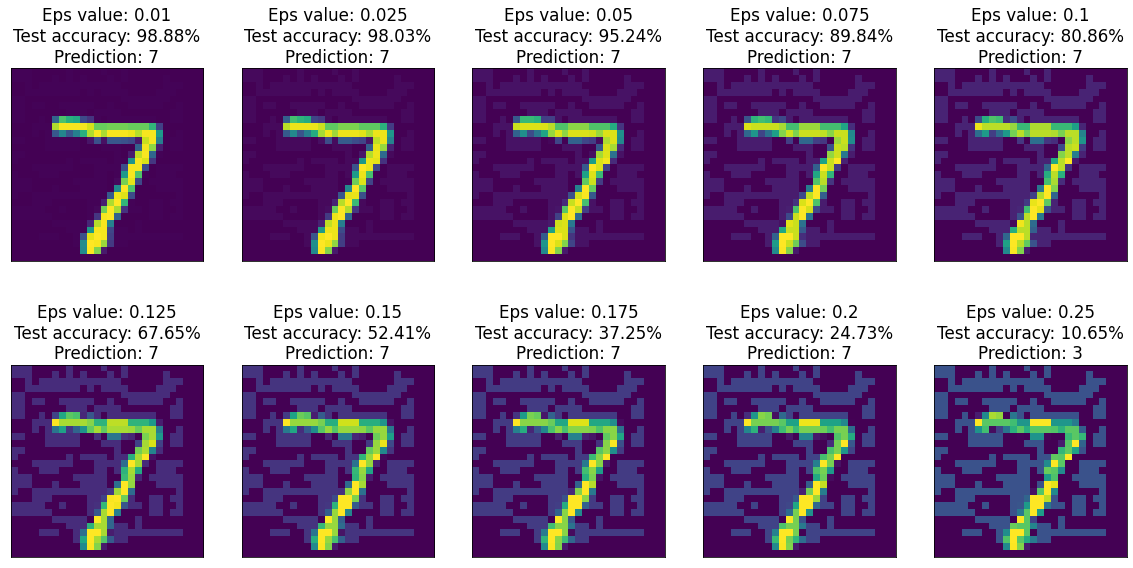

In [20]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        if test_images_adv[0].shape[2] == 1:
          X = test_images_adv[0][:, :, 0]
        axes[i, j].imshow(X)

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

#Part 2 model extraction